In [1]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
from holotomo.holo import G, GT
from holotomo.magnification import M, MT
from holotomo.shift import S, ST
from holotomo.chunking import gpu_batch
import holotomo.chunking as chunking

%matplotlib inline

cp.cuda.Device(0).use()
chunking.global_chunk=20

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)

center = n/2  # rotation axis

# ID16a setup
ndist = 4

detector_pixelsize = 3e-6
energy = 17.05 #[keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208 # [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3,1.7065e-3,2.3975e-3,3.8320e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/magnifications2[0]/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8 # make multiple of 8

## Read data

In [3]:
data00 = np.zeros([ntheta,ndist,n,n],dtype='float32')
ref00 = np.zeros([1,ndist,n,n],dtype='float32')

for k in range(ndist):
    data00[:,k] = dxchange.read_tiff(f'/data/vnikitin/modeling/data_3d_ald_{n}_{k}.tiff')[:ntheta]
    ref00[:,k] = dxchange.read_tiff(f'/data/vnikitin/modeling/ref_3d_ald_{n}_{k}.tiff')
shifts_sample = np.load('/data/vnikitin/modeling/shifts_sample.npy')[:ntheta,:ndist]#/norm_magnifications[:,np.newaxis,np.newaxis]
shifts_ref = np.load('/data/vnikitin/modeling/shifts_ref.npy')[:ntheta,:ndist]#/norm_magnifications[:,np.newaxis,np.newaxis]
shifts_ref0 = np.load('/data/vnikitin/modeling/shifts_ref0.npy')[:,:ndist]#/norm_magnifications[:,np.newaxis,np.newaxis]


# Assuming the shifts are known, shift data and refs back and perform reconstruction with the MultiPaganin

In [4]:
data0 = data00.copy()
ref0 = ref00.copy()
# shifted refs for correction
for k in range(ndist):    
    # shift refs back
    ref0[:,k] = ST(ref0[:,k].astype('complex64'),shifts_ref0[:,k]).real       

ref0c = np.tile(np.array(ref0),(ntheta,1,1,1))
for k in range(ndist):    
    # shift refs the position where they were when collecting data    
    ref0c[:,k] = S(ref0c[:,k].astype('complex64'), shifts_ref[:,k]).real       

In [5]:
rdata = data0/ref0c

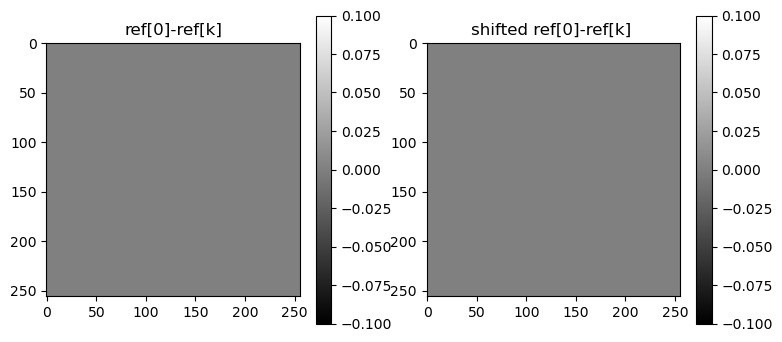

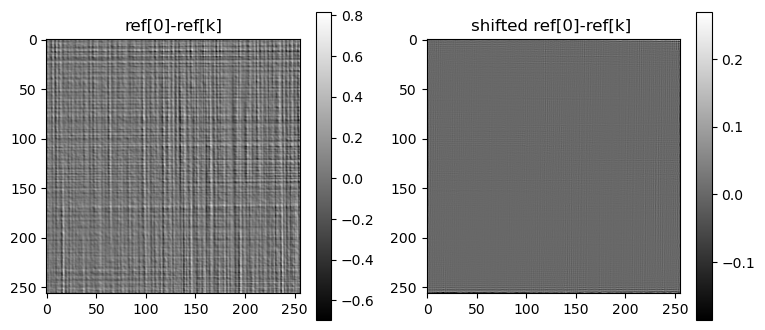

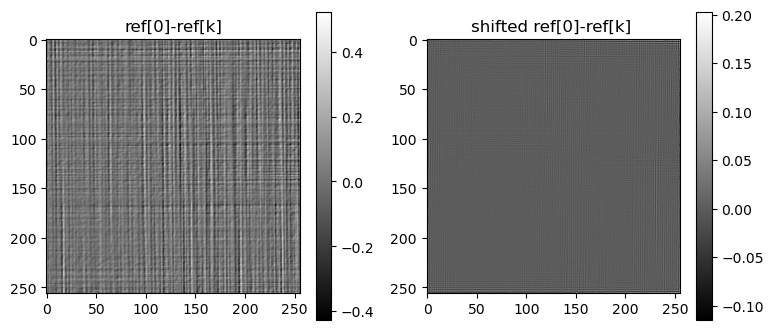

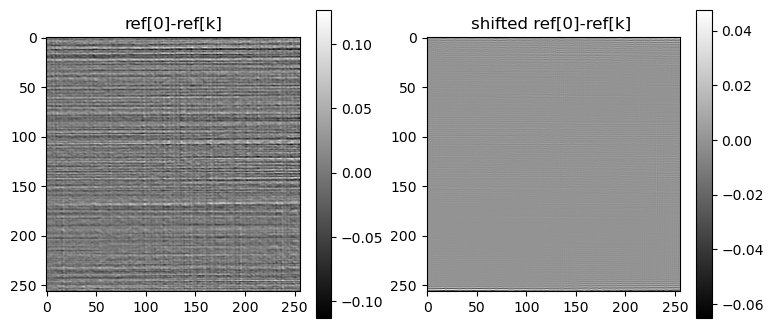

In [6]:
for k in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(ref00[0,0]-ref00[0,k],cmap='gray')
    axs[0].set_title('ref[0]-ref[k]')
    fig.colorbar(im)
    im=axs[1].imshow(ref0[0,0]-ref0[0,k],cmap='gray')#,vmin=-500,vmax=500)
    axs[1].set_title('shifted ref[0]-ref[k] ')
    fig.colorbar(im)

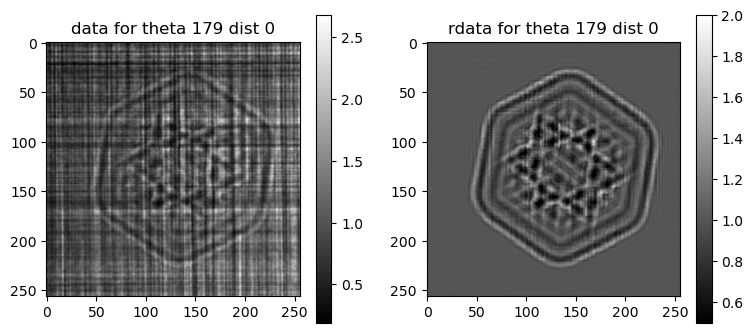

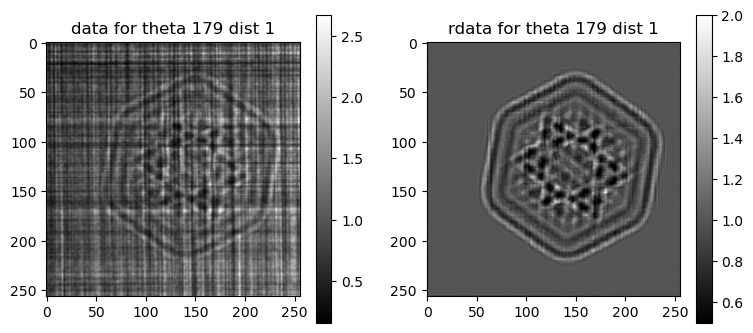

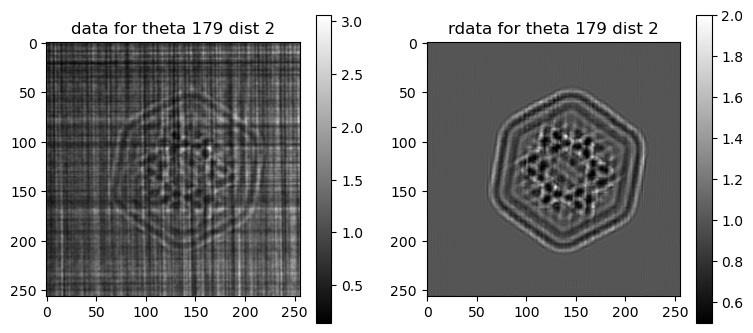

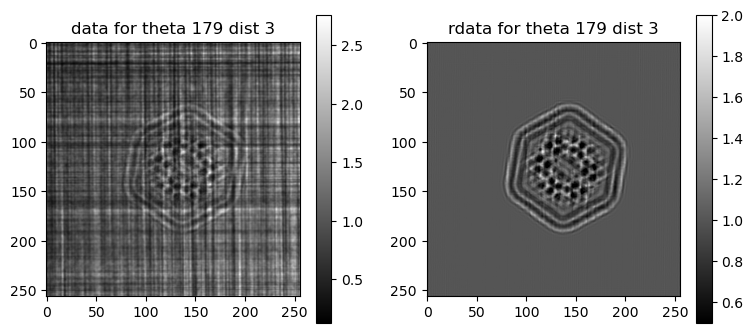

In [7]:
for k in range(ndist):
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(data0[-1,k],cmap='gray')#,vmin = 0.5,vmax=2 )
    axs[0].set_title(f'data for theta {ntheta-1} dist {k}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata[-1,k],cmap='gray',vmin = 0.5,vmax=2)
    axs[1].set_title(f'rdata for theta {ntheta-1} dist {k}')
    fig.colorbar(im)

# Scale images and shift to the same position alogn the beam

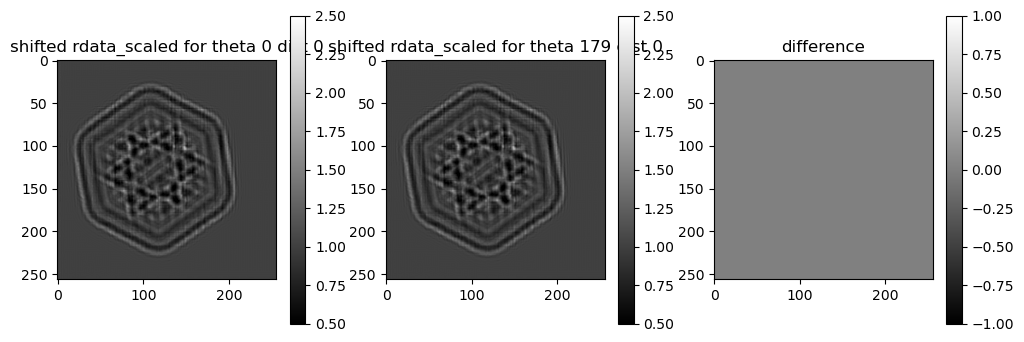

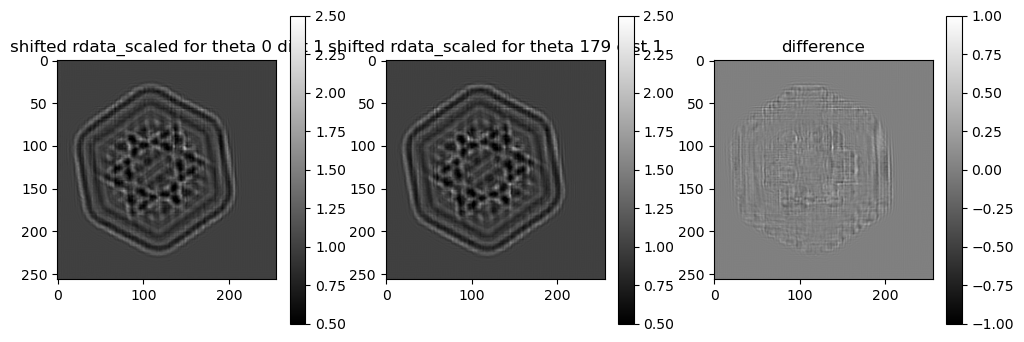

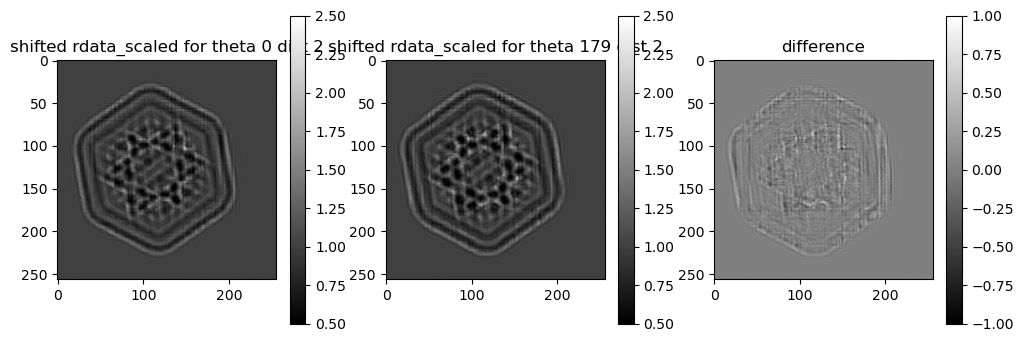

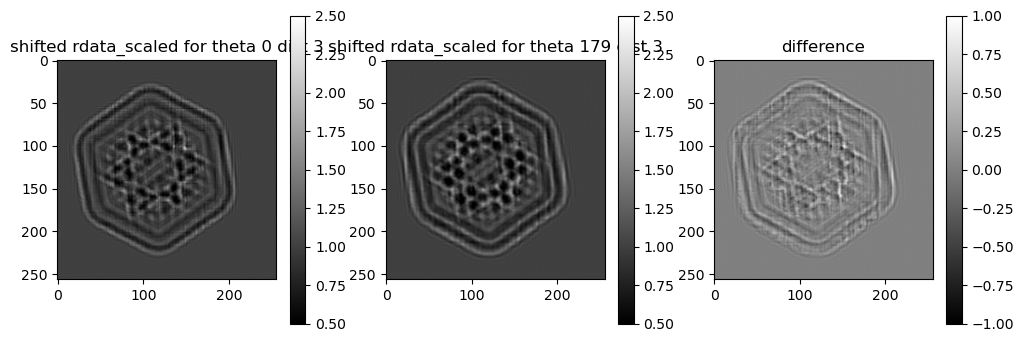

In [8]:
rdata_scaled = rdata.copy()

for k in range(ndist):  
    rdata_scaled[:,k] = M(rdata_scaled[:,k],1/norm_magnifications[k],n).real
    rdata_scaled[:,k] = ST(rdata_scaled[:,k],shifts_sample[:,k]).real

for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    im=axs[0].imshow(rdata_scaled[0,0],cmap='gray',vmin = 0.5,vmax=2.5 )
    axs[0].set_title(f'shifted rdata_scaled for theta 0 dist {k}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata_scaled[0,k],cmap='gray',vmin = 0.5,vmax=2.5 )
    axs[1].set_title(f'shifted rdata_scaled for theta {ntheta-1} dist {k}')
    fig.colorbar(im)        
    im=axs[2].imshow(rdata_scaled[0,k]-rdata_scaled[0,0],cmap='gray',vmin =-1,vmax=1 )
    axs[2].set_title(f'difference')
    fig.colorbar(im)        

In [9]:
def mshow(a):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    im=axs[0].imshow(np.abs(a),cmap='gray')
    axs[0].set_title('reconstructed abs')
    fig.colorbar(im)
    im=axs[1].imshow(np.angle(a),cmap='gray')
    axs[1].set_title('reconstructed phase')
    fig.colorbar(im)                
    # plt.show()     

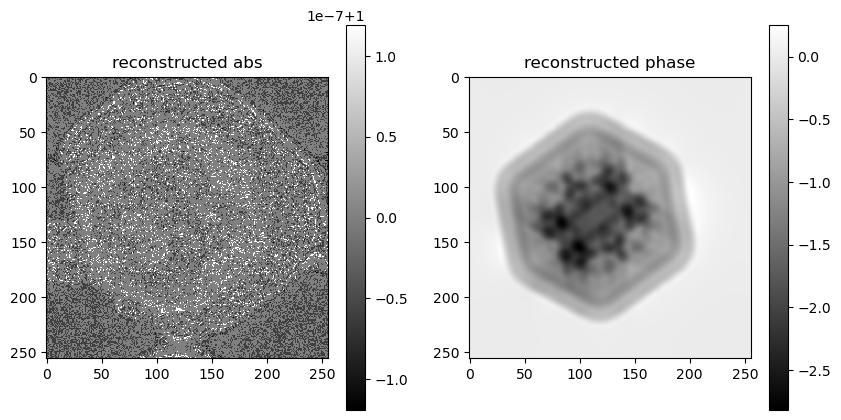

In [10]:

@gpu_batch
def multiPaganin(rads, dists, delta_beta, alpha):
    """
    Phase retrieval method based on the MultiPaganin method
    """    
    fx = cp.fft.fftfreq(n,d=voxelsize).astype('float32')
    [fx,fy] = cp.meshgrid(fx,fx)

    numerator = 0
    denominator = 0    
    for j in range(0, ndist):    
        rad_freq = cp.fft.fft2(rads[:,j])    
        taylorExp = 1 + wavelength * dists[j] * cp.pi * (delta_beta) * (fx**2+fy**2)
        numerator = numerator + taylorExp * (rad_freq)
        denominator = denominator + taylorExp**2 

    numerator = numerator / len(dists)
    denominator = (denominator / len(dists)) + alpha

    phase = cp.log(cp.real(  cp.fft.ifft2(numerator / denominator) ))    
    phase = (delta_beta) * 0.5 * phase

    
    return cp.exp(1j*phase)

# distances should not be normalized 
distances_pag = (distances/norm_magnifications**2)[:ndist]
recMultiPaganin = multiPaganin(rdata_scaled, distances_pag, 100, 1e-12)
mshow(recMultiPaganin[0])
dxchange.write_tiff(np.angle(recMultiPaganin),f'/data/vnikitin/modeling/rec/MultiPaganin.tiff',overwrite=True)

# Construct operators


### Forward holo: $d=\mathcal{G}_{z_j}\left((\mathcal{G}_{z_j'}\mathcal{S}_{s'_{j}}q)\mathcal{M}_j\mathcal{S}_{s_{j}}\psi\right)$, Adjoint holo: $\psi=\sum_j\mathcal{S}^H_{s_j}\mathcal{M}_j^H\left((\mathcal{G}_{z_j'}\mathcal{S}_{s'_{j}}q)^*\mathcal{G}^H_{z_j}d\right)$,  Adjoint holo wrt probe: $q=\sum_{j,k}\mathcal{S}_{s_{k,j}'}\mathcal{G}_{z_j'}^H\left((\mathcal{M}_j\mathcal{S}_{s_{k,j}}\psi_k)^*\mathcal{G}^H_{z_j}d\right)$



In [11]:
from holotomo.chunking import gpu_batch

@gpu_batch
def _fwd_holo(psi, shifts_ref, shifts_sample, prb):
    # print(prb.shape)
    prb = cp.array(prb)
    
    data = cp.zeros([psi.shape[0],ndist,n,n],dtype='complex64')
    for i in range(ndist):        
        #data[i] = fwd_holo_1dist(psi, shifts_ref[i], shifts_sample[i]/norm_magnifications[i], prb, i)
        # ill shift for each acquisition
        prbr = cp.tile(prb,[psi.shape[0],1,1])
        
        prbr = S(prbr, shifts_ref[:,i])    
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[i])
        # object shift for each acquisition
        psir = S(psi, shifts_sample[:,i]/norm_magnifications[i])      
        
        # scale object        
        if ne != n:
            psir = M(psir, norm_magnifications[i]*ne/(n+2*pad), n+2*pad)                
        
        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[i])   
        data[:,i] = psir[:,pad:n+pad,pad:n+pad]
    return data

def fwd_holo(psi,prb):
    return _fwd_holo(psi, shifts_ref, shifts_sample, prb)

@gpu_batch
def _adj_holo(data,shifts_ref,shifts_sample,prb):
    prb = cp.array(prb)    
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64') 
    for j in range(ndist):     
        psir = cp.pad(data[:,j],((0,0),(pad,pad),(pad,pad)))
        
        # propagate data back
        psir = GT(psir, wavelength, voxelsize, distances[j])   
        
        # ill shift for each acquisition
        prbr = cp.tile(prb,[data.shape[0],1,1])
        prbr = S(prbr, shifts_ref[:,j])    
        
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[j])
        
        # multiply the conj ill and object
        psir *= cp.conj(prbr)

        # scale object        
        if ne != n:        
            psir = MT(psir, norm_magnifications[j]*ne/(n+2*pad), ne) 
        # object shift for each acquisition
        psi +=  ST(psir, shifts_sample[:,j]/norm_magnifications[j])  
    return psi

def adj_holo(data,prb):
    return _adj_holo(data,shifts_ref,shifts_sample,prb)

@gpu_batch
def _adj_holo_prb(data, shifts_ref, shifts_sample,psi):    
    prb = cp.zeros([data.shape[0], n+2*pad, n+2*pad], dtype='complex64')
    for j in range(ndist):        
        prbr = np.pad(data[:,j],((0,0),(pad,pad),(pad,pad)))
        psir = psi.copy()
        
        # propagate data back
        prbr = GT(prbr, wavelength, voxelsize, distances[j])   
        
        # object shift for each acquisition
        psir = S(psir, shifts_sample[:,j]/norm_magnifications[j])            
        
        # scale object        
        psir = M(psir, norm_magnifications[j]*ne/(n+2*pad), n+2*pad)                
        
        # multiply the conj object and ill
        prbr *= cp.conj(psir)
        
        # propagate illumination
        prbr = GT(prbr, wavelength,voxelsize,distances2[j])

        # ill shift for each acquisition
        prbr = ST(prbr,shifts_ref[:,j])   
        prb += prbr
    return prb

def adj_holo_prb(data, psi):
    ''' Adjoint Holography operator '''
    return np.sum(_adj_holo_prb(data, shifts_ref, shifts_sample, psi),axis=0)[np.newaxis]

#adjoint test
data = data0.copy()
ref = ref0.copy()
arr1 = np.pad(np.array(data[:,0]+1j*data[:,0]).astype('complex64'),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')
prb1 = np.array(ref[0,:1]+1j*ref[0,:1]).astype('complex64')
prb1 = np.pad(prb1,((0,0),(pad,pad),(pad,pad)))

arr2 = fwd_holo(arr1,prb1)
arr3 = adj_holo(arr2,prb1)
arr4 = adj_holo_prb(arr2, arr1)

print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')
print(f'{np.sum(prb1*np.conj(arr4))}==\n{np.sum(arr2*np.conj(arr2))}')

(253081008+236.3235626220703j)==
(253082112+3.140024273307063e-05j)
(253075680-1938.4609375j)==
(253082112+3.140024273307063e-05j)


### Forward holo without sample: $d=\mathcal{G}_{z_j}\mathcal{S}_{s'_{j}}q$, Adjoint holo without sample: $q=\sum_j\mathcal{S}^H_{s'_{j}}\mathcal{G}^H_{z_j}d$

In [12]:
@gpu_batch
def _fwd_holo0(prb, shifts_ref0):    
    data = cp.zeros([1,ndist, n, n], dtype='complex64')
    for j in range(ndist):
        # ill shift for each acquisition
        prbr = S(prb, shifts_ref0[:,j])                 
        # propagate illumination 
        data[:,j]=G(prbr, wavelength, voxelsize, distances[0])[:,pad:n+pad,pad:n+pad]        
    return data

def fwd_holo0(prb): 
    return _fwd_holo0(prb, shifts_ref0)

@gpu_batch
def _adj_holo0(data, shifts_ref0):    
    prb = cp.zeros([1, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(ndist):                
        # ill shift for each acquisition
        prbr = cp.pad(data[:,j],((0,0),(pad,pad),(pad,pad)))        
        # propagate illumination 
        prbr = GT(prbr, wavelength, voxelsize, distances[0])
        # ill shift for each acquisition
        prb += ST(prbr, shifts_ref0[:,j])     
    return prb

def adj_holo0(data):
    return _adj_holo0(data, shifts_ref0)

# adjoint test
data = data0[0,:].copy()
ref = ref0.copy()
prb1 = np.array(ref[0,:1]+1j*ref[0,:1]).astype('complex64')
prb1 = np.pad(prb1,((0,0),(pad,pad),(pad,pad)))
arr2 = fwd_holo0(prb1)
arr3 = adj_holo0(arr2)

print(f'{np.sum(prb1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')


(575709.5-7.473224639892578j)==
(575724.0625-6.494102308352012e-06j)


0) gammaprb=0.5, err=5.25932e+03


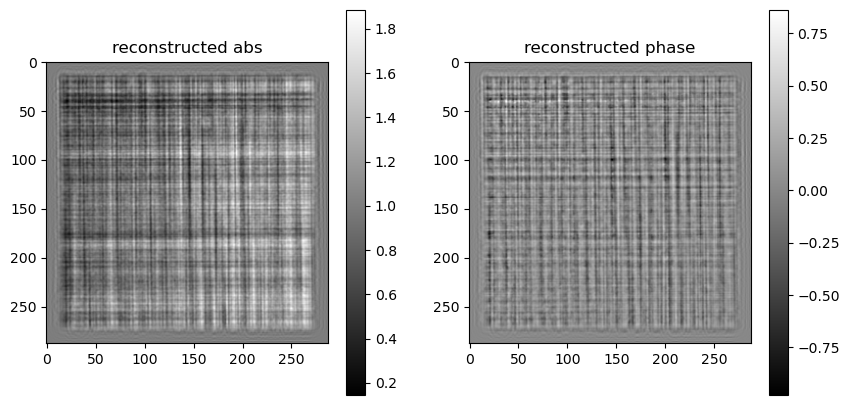

1) gammaprb=0.5, err=4.73774e+01
2) gammaprb=0.5, err=1.95755e+01
3) gammaprb=0.5, err=1.27885e+01
4) gammaprb=0.5, err=7.94146e+00
5) gammaprb=0.5, err=6.59115e+00
6) gammaprb=0.5, err=4.61484e+00
7) gammaprb=0.5, err=4.22783e+00
8) gammaprb=0.5, err=3.72158e+00
9) gammaprb=0.5, err=3.68107e+00
10) gammaprb=0.25, err=2.63955e+00
11) gammaprb=0.125, err=2.09639e+00
12) gammaprb=0.125, err=1.75588e+00
13) gammaprb=0.125, err=1.50999e+00
14) gammaprb=0.25, err=1.50769e+00
15) gammaprb=0.25, err=1.31720e+00
16) gammaprb=0.125, err=1.17734e+00


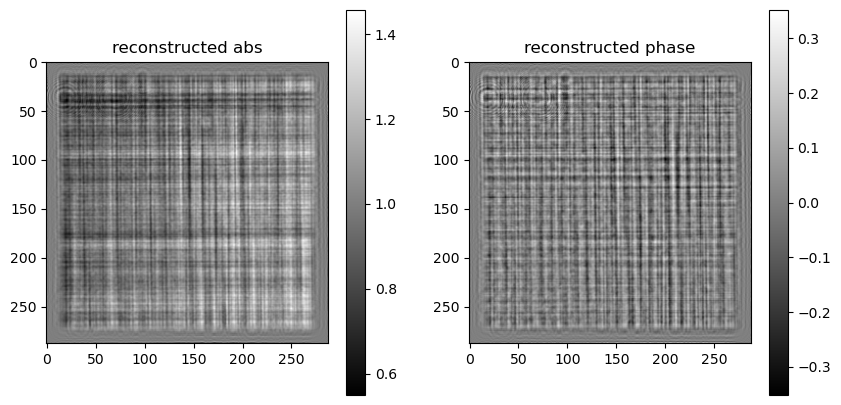

In [13]:
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while(minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def cg_holo(ref, init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fprb):
        f = np.linalg.norm(np.abs(fprb)-ref)**2        
        return f        
    
    ref = np.sqrt(ref)
    prb = init_prb.copy()

    for i in range(pars['niter']):
        fprb0 = fwd_holo0(prb)        
        gradprb = adj_holo0(fprb0-ref*np.exp(1j*np.angle(fprb0)))
        
        if i == 0:
            dprb = -gradprb
        else:
            dprb = -gradprb+np.linalg.norm(gradprb)**2 / \
                ((np.sum(np.conj(dprb)*(gradprb-gradprb0))))*dprb
        gradprb0 = gradprb
        
        # line search
        fdprb0 = fwd_holo0(dprb)        
        gammaprb = line_search(minf,pars['gammaprb'], fprb0, fdprb0)
        prb = prb + gammaprb*dprb
        
        if i%pars['err_step']==0:
            fprb0 = fwd_holo0(prb) 
            err = minf(fprb0)
            print(f'{i}) {gammaprb=}, {err=:1.5e}')  
                    
        if i%pars['vis_step']==0:  
            mshow(prb[0])
            
    return prb

rec_prb0 = np.ones([1,n+2*pad,n+2*pad],dtype='complex64') 
ref = ref00.copy()
pars = {'niter': 17, 'err_step': 1, 'vis_step': 16, 'gammaprb': 0.5}
rec_prb0 = cg_holo(ref, rec_prb0, pars)

#### $\ \sum_k\sum_j||\mathcal{G}_{z_j}((\mathcal{G}_{z'_j}q)(M_j S_{s_{kj}}\psi_k))|-\sqrt{d_{kj}}\|^2_2 + \||\mathcal{G}_{z_0}q|-\sqrt{d^r}\|_2^2\to \text{min}_{\psi_k,q}$ 

0) gammapsi=0.5 gammaprb=0.5, err=9.98796e+03
[1.07481194 0.09250975 0.49903846 0.29845691 0.90377736 0.50507593
 0.30001736] 3.673687696456909


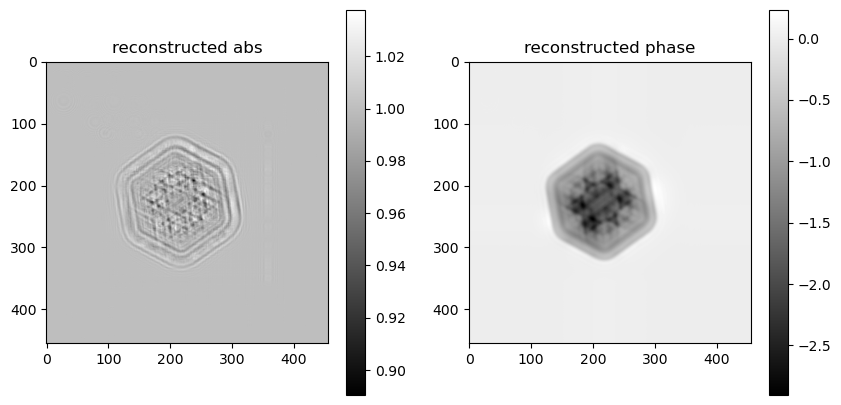

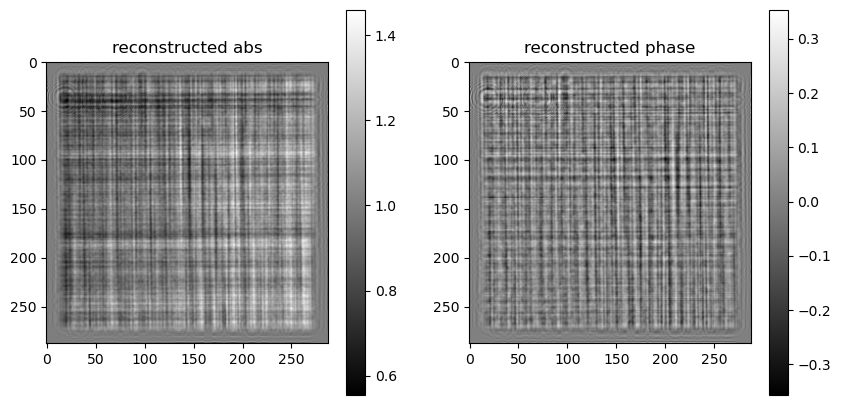

4) gammapsi=0.5 gammaprb=0.25, err=2.82465e+03
[1.03044963 0.42354536 0.50094938 0.30291629 0.90579295 0.50690675
 0.60751319] 4.27807354927063
8) gammapsi=0.5 gammaprb=0.5, err=1.94109e+03
[1.02946782 0.42429805 0.50046015 0.30016208 0.89545417 0.5074749
 0.30723047] 3.964547634124756
12) gammapsi=0 gammaprb=0.25, err=1.66507e+03
[1.03199005 0.42735243 0.50092769 2.11839271 0.9019115  0.50772572
 0.60400081] 6.092300891876221
16) gammapsi=0.5 gammaprb=0.5, err=1.40476e+03
[1.03120255 0.42513943 0.50152183 0.30120754 0.89684129 0.50611401
 0.29981446] 3.961841106414795
20) gammapsi=0.5 gammaprb=0.5, err=1.19992e+03
[1.0299108  0.42230582 0.50043607 0.30197883 0.90533233 0.5054388
 0.3017168 ] 3.9671194553375244
24) gammapsi=0.25 gammaprb=0.5, err=1.12408e+03
[1.03075266 0.42592621 0.50162959 0.60580158 0.89951563 0.50562191
 0.30067515] 4.269922733306885
28) gammapsi=0.125 gammaprb=0.5, err=1.04072e+03
[1.03080535 0.4252553  0.50046444 0.90347219 0.89925694 0.50699925
 0.30220747] 4.56

: 

In [14]:

def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma >= 1/64):
        gamma *= 0.5
    if(gamma < 1/64):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

@gpu_batch
def _gradient(psi,data,shifts_ref,shifts_sample,prb):
    prb = cp.array(prb)
    res = cp.zeros([psi.shape[0],ne,ne],dtype='complex64')
    fpsires = cp.zeros([psi.shape[0],ndist,n,n],dtype='complex64')
    for j in range(ndist):       
        # ill shift for each acquisition
        prbr = cp.tile(prb,[psi.shape[0],1,1])
        prbr = S(prbr, shifts_ref[:,j])    
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[j])
        # object shift for each acquisition
        psir = S(psi, shifts_sample[:,j]/norm_magnifications[j])      
        
        # scale object        
        if ne != n:
            psir = M(psir, norm_magnifications[j]*ne/(n+2*pad), n+2*pad)                
        
        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[j])   
        fpsi = psir[:,pad:n+pad,pad:n+pad]
        fpsires[:,j] = fpsi

    ###########################
        psir = fpsi-data[:,j]*np.exp(1j*(np.angle(fpsi)))

        psir = cp.pad(psir,((0,0),(pad,pad),(pad,pad)))
        
        # propagate data back
        psir = GT(psir, wavelength, voxelsize, distances[j])   
        
        # ill shift for each acquisition
        prbr = cp.tile(prb,[psi.shape[0],1,1])
        prbr = S(prbr, shifts_ref[:,j])    
        
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[j])
        
        # multiply the conj ill and object
        psir *= cp.conj(prbr)

        # scale object        
        if ne != n:        
            psir = MT(psir, norm_magnifications[j]*ne/(n+2*pad), ne) 
        # object shift for each acquisition
        res +=  ST(psir, shifts_sample[:,j]/norm_magnifications[j])     
    
    res/=cp.amax(cp.abs(prb))**2
    return [res,fpsires]

def gradient(psi,data, prb):
    ''' Gradient wrt psi'''
    return _gradient(psi,data,shifts_ref,shifts_sample,prb)

@gpu_batch
def _gradientprb(psi,data,shifts_ref,shifts_sample,prb):
    prb = cp.array(prb)
    res = cp.zeros([psi.shape[0],n+2*pad,n+2*pad],dtype='complex64')
    fpsires = cp.zeros([psi.shape[0],ndist,n,n],dtype='complex64')
    for j in range(ndist):       
        # ill shift for each acquisition
        prbr = cp.tile(prb,[psi.shape[0],1,1])
        prbr = S(prbr, shifts_ref[:,j])    
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[j])
        # object shift for each acquisition
        psir = S(psi, shifts_sample[:,j]/norm_magnifications[j])      
        
        # scale object        
        if ne != n:
            psir = M(psir, norm_magnifications[j]*ne/(n+2*pad), n+2*pad)                
        
        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[j])   
        fpsi = psir[:,pad:n+pad,pad:n+pad]
        fpsires[:,j] = fpsi

    ###########################
        fpsi = fpsi-data[:,j]*np.exp(1j*(np.angle(fpsi)))
        
        prbr = np.pad(fpsi,((0,0),(pad,pad),(pad,pad)))
        psir = psi.copy()
        
        # propagate data back
        prbr = GT(prbr, wavelength, voxelsize, distances[j])   
        
        # object shift for each acquisition
        psir = S(psir, shifts_sample[:,j]/norm_magnifications[j])            
        
        # scale object        
        psir = M(psir, norm_magnifications[j]*ne/(n+2*pad), n+2*pad)                
        
        # multiply the conj object and ill
        prbr *= cp.conj(psir)
        
        # propagate illumination
        prbr = GT(prbr, wavelength,voxelsize,distances2[j])

        # ill shift for each acquisition
        prbr = ST(prbr,shifts_ref[:,j])   
        res += prbr         

    return [res,fpsires]

def gradientprb(psi,data, prb):
    ''' Gradient wrt prb'''
    [gradprb,fprb] = _gradientprb(psi,data,shifts_ref,shifts_sample,prb)
    gradprb = np.sum(gradprb,axis=0)[np.newaxis]
    return [gradprb,fprb]

import time 
def cg_holo(data, ref, init, init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional

    def minf(fpsi,fprb):
        f = np.linalg.norm(np.abs(fpsi)-data)**2            
        if isinstance(fprb,np.ndarray):
            f += np.linalg.norm(np.abs(fprb)-ref)**2        
        return f      
      
    data = np.sqrt(data)
    ref = np.sqrt(ref)
    
    psi = init.copy()
    prb = init_prb.copy()
    conv = np.zeros(pars['niter'])
    
    tt = np.zeros([7])
    for i in range(pars['niter']):
        if pars['upd_psi']:

            t= time.time()
            [grad,fpsi] = gradient(psi, data, prb)    
            tt[0] = t-time.time()            

            # Dai-Yuan direction
            t= time.time()
            if i == 0:
                d = -grad
            else:
                d = -grad+np.linalg.norm(grad)**2 / \
                    ((np.sum(np.conj(d)*(grad-grad0))))*d
            tt[1] = t-time.time()
        
            grad0 = grad
            t= time.time()
            fd = fwd_holo(d, prb)     
            tt[2] = t-time.time()

            t= time.time()
            gammapsi = line_search(minf,pars['gammapsi'], fpsi, 0, fd, 0)
            tt[3] = t-time.time()      

            psi = psi+gammapsi*d
            
        if pars['upd_prb']:
            t= time.time()
            [gradprb,fprb] = gradientprb(psi, data, prb)
            tt[4] = t-time.time()

            fprb0 = fwd_holo0(prb)
            gradprb += adj_holo0(fprb0-ref*np.exp(1j*np.angle(fprb0)))
            gradprb*=1/(ntheta+1)
            
            # Dai-Yuan direction
            if i == 0:
                dprb = -gradprb
            else:
                dprb = -gradprb+np.linalg.norm(gradprb)**2 / \
                    ((np.sum(np.conj(dprb)*(gradprb-gradprb0))))*dprb
            gradprb0 = gradprb
            
            t= time.time()
            # line search
            fdprb = fwd_holo(psi, dprb)
            fdprb0 = fwd_holo0(dprb)
            tt[5] = t-time.time()
            
            t= time.time()
            gammaprb = line_search(minf,pars['gammaprb'], fprb, fprb0, fdprb, fdprb0)
            tt[6] = t-time.time()

            prb = prb + gammaprb*dprb

        if i%pars['err_step']==0:
            fprb = fwd_holo(psi,prb)
            fprb0 = fwd_holo0(prb) 
            err = minf(fprb,fprb0)
            conv[i] =err
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}')  
            print(-tt,-np.sum(tt))
            
        
        if i%pars['vis_step']==0:  
            mshow(psi[0])
            mshow(prb[0])            
            # dxchange.write_tiff(cp.angle(psi).get(),f'/data/vnikitin/modeling/r_{n}_{ntheta}_{ndist}/r{i:05}.tiff',overwrite=True)
            # dxchange.write_tiff(cp.abs(psi).get(),f'/data/vnikitin/modeling/rabs_{n}_{ntheta}_{ndist}/r{i:05}.tiff',overwrite=True)
            # dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/modeling/r_{n}_{ntheta}_{ndist}/o{i:05}.tiff',overwrite=True)
            # dxchange.write_tiff(cp.abs(prb[0]).get(),f'/data/vnikitin/holo/3d_ald_syn/pabs_{n}_{ntheta}_{ndist}/o{i:05}.tiff',overwrite=True)
            # dxchange.write_tiff(cp.angle(prb[0]).get(),f'/data/vnikitin/modeling/3d_ald_syn/pangle_{n}_{ntheta}_{ndist}/o{i:05}.tiff',overwrite=True)            
            
            
    return psi,prb,conv

rec = np.pad(recMultiPaganin, ((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')# cp.ones([ntheta,ne,ne],dtype='complex64')
rec_prb = rec_prb0.copy()
ref = ref00.copy()
data = data00.copy()

pars = {'niter': 2049, 'upd_psi': True, 'upd_prb': True, 'err_step': 4, 'vis_step': 128, 'gammapsi': 0.5, 'gammaprb':0.5}
rec,rec_prb,conv = cg_holo(data,ref,rec,rec_prb,pars)

In [ ]:
plt.imshow(cp.angle(rec[0,100:200,100:200]).get(),cmap='gray')
plt.colorbar()

# plt.show()
plt.loglog(np.arange(0,pars['niter'],4),conv[::4])


In [ ]:
plt.imshow(cp.angle(rec[0,100:200,100:200]).get(),cmap='gray')
plt.colorbar()

# plt.show()
plt.loglog(np.arange(0,pars['niter'],4),conv[::4])
